# import


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd


In [2]:
plt.rcParams['figure.figsize'] = [15, 15]

In [3]:
def rescaleData(data, mindata=0, maxdata=1):
	return np.interp(data, (data.min(), data.max()), (mindata, maxdata))

In [4]:
avifile='/media/hydroassist/B0C0-D696/0629-3/20200629r-b-dish-noise-3.avi'

# get background

In [5]:
capture = cv2.VideoCapture(avifile)
backSub = cv2.createBackgroundSubtractorMOG2()

if not capture.isOpened:
    print('Unable to open: ' + file)
    exit(0)
    
totalN = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
imgW = capture.get(cv2.CAP_PROP_FRAME_WIDTH)
imgH = capture.get(cv2.CAP_PROP_FRAME_HEIGHT)
print('width=' , imgW)
print('height=', imgH)
print('length=',totalN)
cv2.namedWindow("Frame",0);
cv2.resizeWindow("Frame", 1000, 1000);
cv2.namedWindow("background",0);
cv2.resizeWindow("background", 1000, 1000);

# while True:
for j in range(1):
    capture = cv2.VideoCapture(avifile)
    for ID in range(60,1060):
        capture.set(cv2.CAP_PROP_POS_FRAMES, ID)
        ret, frame = capture.read()
        if frame is None:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        fgMask = backSub.apply(gray)
        bgimg = backSub.getBackgroundImage()

        
        cv2.rectangle(frame, (10, 2), (300,60), (255,255,255), -1)
        cv2.putText(frame, str(capture.get(cv2.CAP_PROP_POS_FRAMES)), (10, 40), cv2.FONT_HERSHEY_TRIPLEX, 2 , (0,0,0),3)
        cv2.imshow('Frame', frame)
        cv2.imshow('background', bgimg)
#         cv2.imshow('FG Mask', fgMask)


        keyboard = cv2.waitKey(30)
        if keyboard == 'q' or keyboard == 27:
            break
capture.release()  
cv2.destroyAllWindows() 

width= 1600.0
height= 1600.0
length= 3549


In [20]:
capture.release()
cv2.destroyAllWindows()

In [6]:
imgbg = bgimg.copy()

In [7]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

# detect volvox

In [22]:
cv2.namedWindow("detected circles",0);
cv2.resizeWindow("detected circles", 1000, 1000);

cap = cv2.VideoCapture(avifile)
nframes = 3549
data=np.array([[0,0,0,0]]) # x,y, radius,frameID
for frameID in range(nframes):
    cap.set(1,frameID) # (1, # of frame)
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    imgdiff=gray.astype(float)-imgbg.astype(float)
    imgdiff[np.where(imgdiff<0)]=0
    imgrescale = rescaleData(imgdiff, mindata=0, maxdata=255)
    imgrescale = imgrescale.astype('uint8')
    ret,thimg = cv2.threshold(imgrescale,30,255,cv2.THRESH_BINARY_INV)
    closingimg = cv2.morphologyEx(thimg,cv2.MORPH_CLOSE,kernel)
    closingimg = cv2.morphologyEx(closingimg,cv2.MORPH_CLOSE,kernel)
    circles = cv2.HoughCircles(closingimg,cv2.HOUGH_GRADIENT,1,10,param1=50,param2=10,minRadius=5,maxRadius=15)
    outputimg = frame.copy()

    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(outputimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(outputimg,(i[0],i[1]),2,(0,0,255),3)
        cv2.rectangle(outputimg, (10, 2), (300,60), (255,255,255), -1)
        cv2.putText(outputimg, str(cap.get(cv2.CAP_PROP_POS_FRAMES)), (10, 40), cv2.FONT_HERSHEY_TRIPLEX, 2 , (0,0,0),3)
    cv2.imshow('detected circles',outputimg)
    cv2.waitKey(10)

    tempdata = np.append(circles[0],np.array([[frameID]*circles[0].shape[0]]).T,axis=1)
    data=np.append(data,tempdata,axis=0)
data = np.delete(data,0,0)
dataset = pd.DataFrame({'x':data[:,0],'y':data[:,1],'radius':data[:,2],'frame':data[:,3]})

cap.release()
cv2.destroyAllWindows()

In [9]:
cap.release()
cv2.destroyAllWindows()

# trackpy to create the trajectory

In [23]:
import trackpy as tp

In [13]:
def distance2D(x,y):
	return ((x[1:]-x[0:-1])**2+(y[1:]-y[0:-1])**2)**0.5

def velocity2D(x=[],y=[],t=[]):
	return (((x[1:]-x[0:-1])**2+(y[1:]-y[0:-1])**2)**0.5)/(t[1:]-t[0:-1])

In [67]:
dataset.head()

frame  radius       x       y
0    0.0     8.7  1056.5   555.5
1    0.0     7.4  1476.5  1031.5
2    0.0     8.2   815.5   267.5
3    0.0    10.3   141.5   446.5
4    0.0     8.0   863.5   676.5

In [65]:
datalink = tp.link_df(dataset, 10, memory=5)

Frame 3548: 267 trajectories present.


In [25]:
datalink.head()

frame  radius       x      y  particle
0        0     8.7  1056.5  555.5         0
117      0     6.2    58.5  703.5         1
118      0     6.2  1286.5  235.5         2
119      0     6.2  1452.5  420.5         3
120      0     6.0   189.5  881.5         4

In [86]:
filterlink = tp.filter_stubs(datalink, 100)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', datalink['particle'].nunique())
print('After:', filterlink['particle'].nunique())

Before: 81317
After: 1197


In [48]:
filterlink.head()

frame  radius       x       y  particle
frame                                         
0          0     8.7  1056.5   555.5         0
0          0     6.0   189.5   881.5         4
0          0     5.5   529.5   731.5         5
0          0     5.5   930.5  1125.5         7
0          0     6.9  1501.5   456.5         9

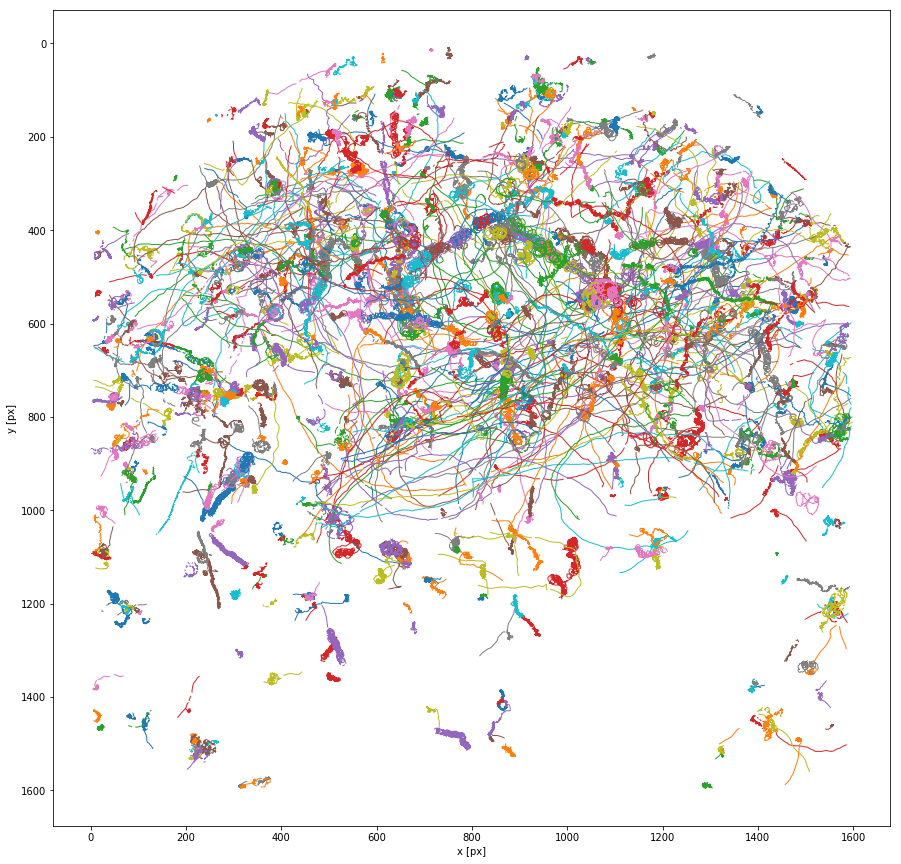

In [87]:
plt.figure(figsize=(15,15))
tp.plot_traj(filterlink, label=False)

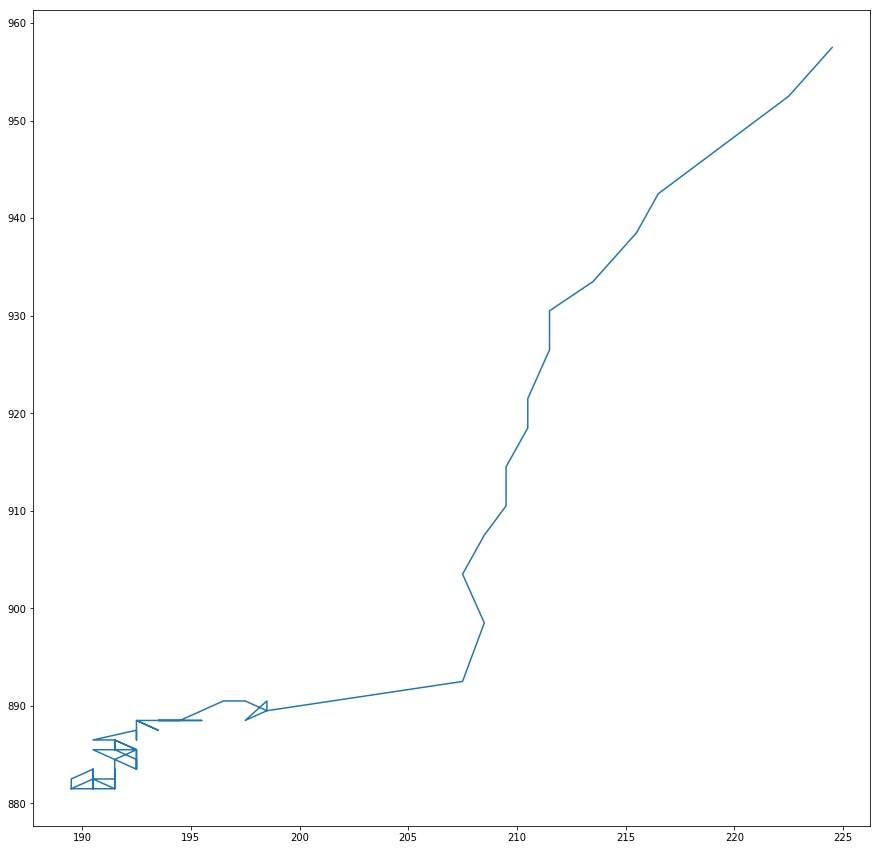

In [41]:
filterid = (datalink['particle']==4)
x=datalink[filterid]['x'].values
y=datalink[filterid]['y'].values

plt.plot(x,y)
plt.show()

In [32]:
pd.unique(filterlink['particle'].values)

array([    0,     4,     5, ..., 73205, 73219, 73389])

In [88]:
IDcounts = []
meanR = []
stdR = []
meanV = [] 
stdV = []
ID = []
travelL = []
absV = []
maxmove = []
for vID in pd.unique(filterlink['particle'].values):
    filterid = (filterlink['particle']==vID)
    IDcounts.append(filterlink[filterid].shape[0])
    x=filterlink[filterid]['x'].values
    y=filterlink[filterid]['y'].values
    t=filterlink[filterid]['frame'].values
    r=filterlink[filterid]['radius'].values
    meanR.append(r.mean())
    stdR.append(r.std())
    meanV.append(velocity2D(x=x,y=y,t=t).mean())
    stdV.append(velocity2D(x=x,y=y,t=t).std())
    travelL.append(np.sum(distance2D(x,y)))
    absV.append(np.sum(distance2D(x,y))/(max(t)-min(t)))
    maxmove.append(max((max(x)-min(x)),(max(y)-min(y))))
    ID.append(vID)
    
trackinfo = pd.DataFrame({'IDcounts':IDcounts,'meanR':meanR,'stdR':stdR,'meanV':meanV,'stdV':stdV,'absV':absV,'travelL':travelL,'maxmove':maxmove,'ID':ID})

In [89]:
filterinfo = trackinfo.loc[(trackinfo['maxmove'] >= 300)].sort_values(by='IDcounts',ascending=False)

In [70]:
filterinfo.head()

ID  IDcounts      absV  maxmove     meanR     meanV      stdR  \
363  17808      1791  1.728728    368.0  7.770352  1.745240  0.935430   
27     107      1372  1.881272    344.0  8.778353  1.913259  0.802696   
16      58      1163  0.834297    309.0  6.086070  0.837433  0.630123   
206   8067       760  1.675292    303.0  8.212368  1.740496  0.861321   
577  30418       502  5.341485    470.0  7.473705  5.479432  0.745121   

         stdV      travelL  
363  1.323914  3201.604814  
27   1.453145  2673.286949  
16   1.487626   986.973128  
206  1.530234  1372.064519  
577  1.322311  2782.913546

In [71]:
filterinfo.shape

(92, 9)

In [72]:
imgW = 1600
imgH = 1600

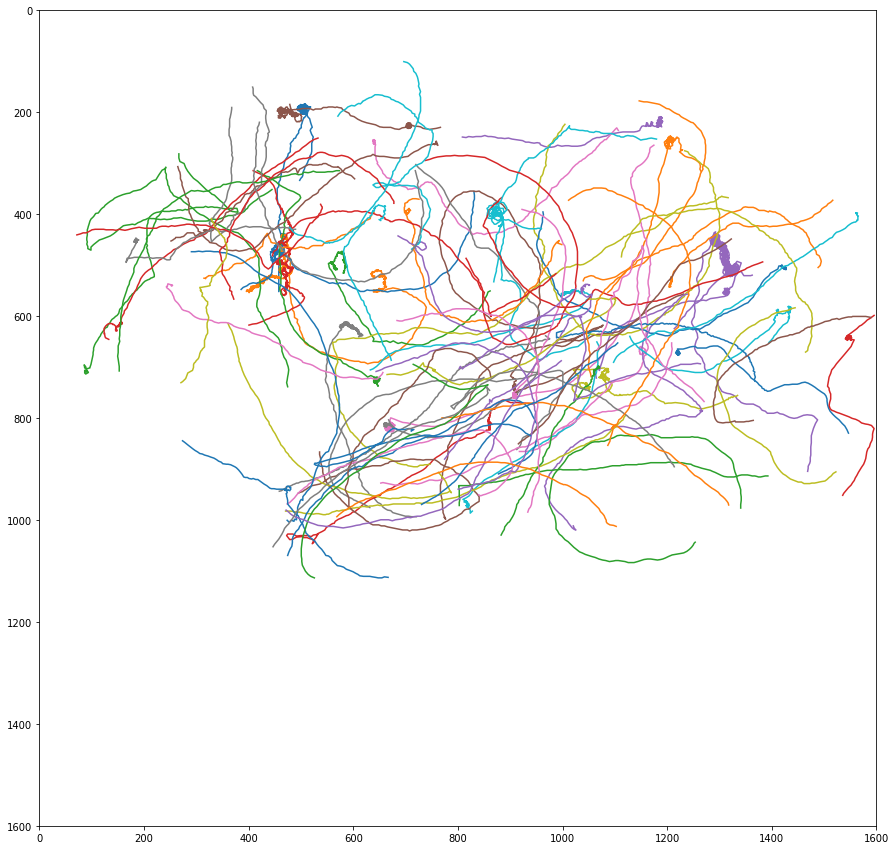

In [90]:
# %%script false
plt.figure(figsize=(15,15))
for i in filterinfo['ID'].values:
    filterid = (filterlink['particle']==i)
    x=filterlink[filterid]['x'].values
    y=filterlink[filterid]['y'].values
    plt.plot(x,y)
    plt.xlim([0,imgW])
    plt.ylim([0,imgH])
    plt.gca().invert_yaxis()
plt.show()

In [ ]:
# %%script false
trackfile=avifile[:-4]+'_track.pkl'
trackinfofile=avifile[:-4]+'_trackinfo.pkl'

datalink.to_pickle(trackfile)
trackinfo.to_pickle(trackinfofile)

In [76]:
trackfile=avifile[:-4]+'_track.pkl'

In [77]:
trackfile

'/media/hydroassist/B0C0-D696/0629-3/20200629r-b-dish-noise-3_track.pkl'